In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np
import statsmodels.api as sm


##File import related
#------------------------------------------------------
# read in file
stata_file_path = '/Users/arikimelman/Downloads/Analytics-Portfolio/randhrs1992_2020v1.dta'

# Specify the columns to load in 
columns_to_load = ['hhidpn', 'h3atran', 'h4atran', 'h5atran', 'r3whappy', 'r4whappy', 'r5whappy']

# Load in specified columns from the df
df = pd.read_stata(stata_file_path, columns=columns_to_load)

# Create an empty DataFrame to store the result
result_df = pd.DataFrame()
#------------------------------------------------------

In [9]:
##Data cleaning of columns imported.
#------------------------------------------------------

#tracker for number of rows with zero being dropped. 
numberRowsZero = 0
for i in range(3, 6):
    atran_col = f'h{i}atran'
    whappy_col = f'r{i}whappy'

    # Make sure both columns (happy or not & Vehicle net worth) is not 'nan' 
    temp_df = df.dropna(subset=[atran_col, whappy_col])

    #Track number of rows removed when removing vehicle worth = 0
    numberRowsZero += len(temp_df[temp_df[atran_col] == 0])
    
    # Remove 0s from vehicle column 
    temp_df = temp_df.loc[temp_df[atran_col] != 0]

    # Keep only the first occurrence for each hhidpn
    # We only keep first occurance of both measures because there are repeated values for a single identity because it is longitudinal data
    temp_df = temp_df.groupby('hhidpn').first().reset_index()[['hhidpn', atran_col, whappy_col]]

    # Add the wave the info was gathered from
    temp_df['wave'] = i

    # Rename columns for readability
    temp_df.rename(columns={atran_col: 'Car_value', whappy_col: 'happy'}, inplace=True)

    # append to empty df 'result_df' we created
    result_df = pd.concat([result_df, temp_df])

# Reset index of final result DataFrame for readibility
result_df.reset_index(drop=True, inplace=True)

#refine newly created dataframe back to 'df'
df = result_df

# clean happy column only keeping 'yes' or 'no' as the column is not in correct form
df['happy'] = df['happy'].apply(lambda x: x[2:] if pd.notnull(x) else x)

#turn yes and no into... Yes = 1, No =0
df['happy'] = df['happy'].map({'yes': 1, 'no': 0})

#Convert the 1 & 0 ino ints
df['happy'] = df['happy'].astype(int)
#------------------------------------------------------


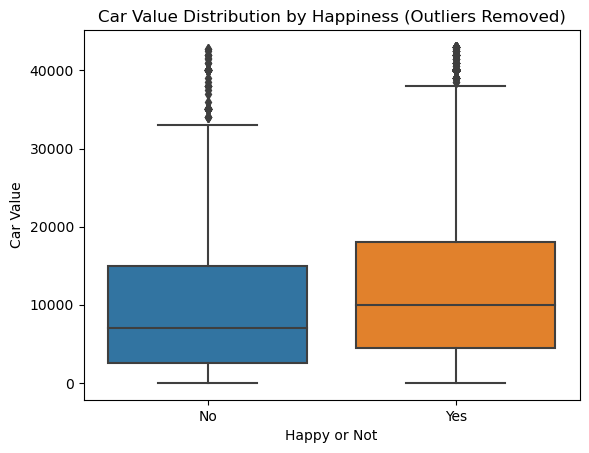

In [10]:
##Side by side boxplots of categories 'happy or not' and net vehicle value
#------------------------------------------------------
# Duplicate Car_value for visualization purposes
df['car_value_for_visualization'] = df['Car_value']

# Calculate Q1 and Q3 for the car_value_for_visualization column
Q1_viz = df['car_value_for_visualization'].quantile(0.25)
Q3_viz = df['car_value_for_visualization'].quantile(0.75)

# Calculate the Interquartile Range (IQR)
IQR_viz = Q3_viz - Q1_viz

# Define lower and upper bounds for outliers
lower_bound_viz = Q1_viz - 1.5 * IQR_viz
upper_bound_viz = Q3_viz + 1.5 * IQR_viz

# Remove outliers only in the visualization column by setting them to NaN
df['car_value_for_visualization'] = df['car_value_for_visualization'].where(
    (df['car_value_for_visualization'] > lower_bound_viz) & (df['car_value_for_visualization'] < upper_bound_viz))

print("\n")
print("\n")

# Now, use car_value_for_visualization for the boxplot
sns.boxplot(x='happy', y='car_value_for_visualization', data=df)
plt.title('Car Value Distribution by Happiness (Outliers Removed)')
plt.xlabel('Happy or Not')
plt.ylabel('Car Value')
plt.xticks([0, 1], ['No', 'Yes'])
plt.show()
#------------------------------------------------------


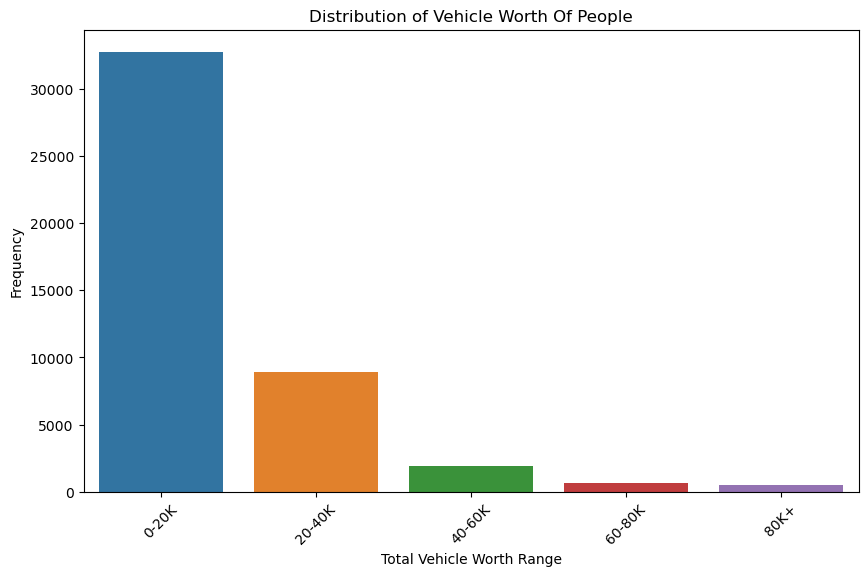

------------------------------------------------------------
MODEL BUILDING
------------------------------------------------------------


In [11]:

##Creating bar plot of everybody's vehicle values
#------------------------------------------------------
#Define bins, labels, and new column to create plot to show distribution of car prices.
bins = [0, 20000, 40000, 60000, 80000, np.inf]
labels = ['0-20K', '20-40K', '40-60K', '60-80K', '80K+']
df['Car_value_group'] = pd.cut(df['Car_value'], bins=bins, labels=labels, right=False)

# Plotting the distribution of car prices 
plt.figure(figsize=(10, 6))
sns.countplot(x='Car_value_group', data=df)
plt.title('Distribution of Vehicle Worth Of People')
plt.xlabel('Total Vehicle Worth Range')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

print('-'*60)
print("MODEL BUILDING")
print('-'*60)
#----------------------------------------------------

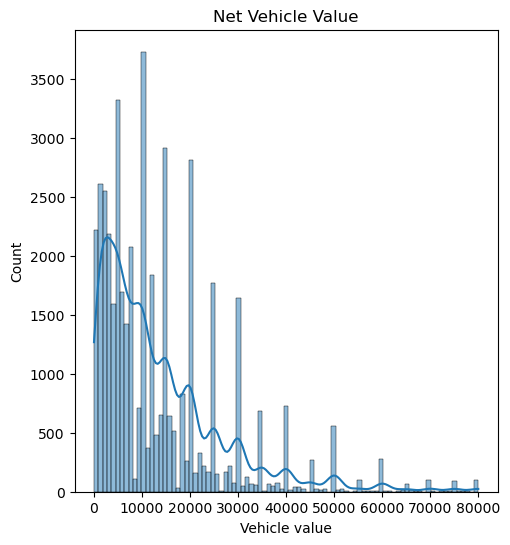

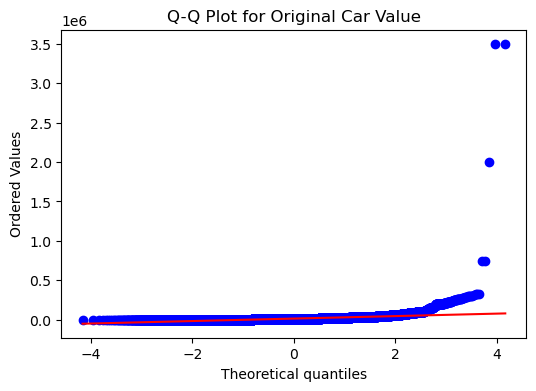

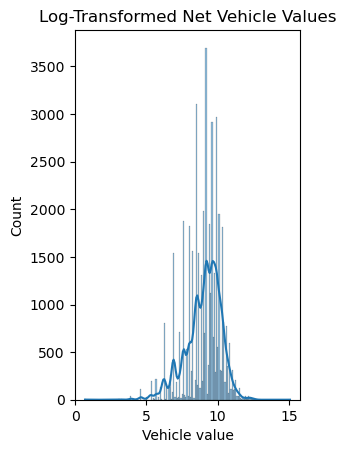

<Figure size 640x480 with 0 Axes>

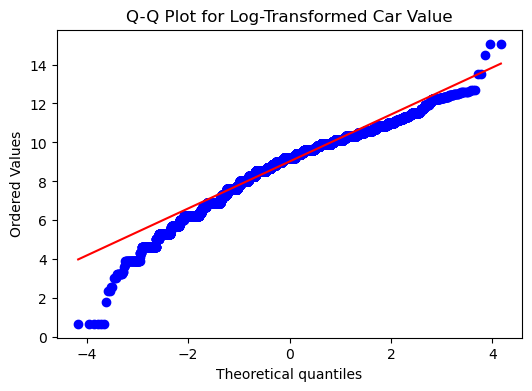

Plot demonstrates sufficient normality after transformation


In [6]:
## Creating qqplots & histograms
#------------------------------------------------------
#two part here
# 1. Plot the car_value distribution. 
# 2. Include up until only the 99th percentile for the plot for readability

# Calculate the 99th percentile of Car_value
percentile_99 = df['Car_value'].quantile(0.99)

# create the plot
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(df[df['Car_value'] <= percentile_99]['Car_value'], kde=True)
plt.title('Net Vehicle Value')
plt.xlabel('Vehicle value')  

# Create a Q-Q plot for original Car_value
plt.figure(figsize=(6, 4))
stats.probplot(df['Car_value'], dist="norm", plot=plt)
plt.title('Q-Q Plot for Original Car Value')
plt.show()

# Apply log transformation to 'car_value' because it appears to be right-skewed.
df['Car_value_log'] = np.log(df['Car_value'] + 1)

# Plotting the transformed 'car_value' distribution
plt.subplot(1, 2, 2)
sns.histplot(df['Car_value_log'], kde=True)
plt.title('Log-Transformed Net Vehicle Values')
plt.xlabel('Vehicle value')  
plt.show()

plt.tight_layout()
plt.show()

# Q-Q plot for Log-Transformed Car_value to check normality 
plt.figure(figsize=(6, 4))
stats.probplot(df['Car_value_log'], dist="norm", plot=plt)
plt.title('Q-Q Plot for Log-Transformed Car Value')
plt.show()
print("Plot demonstrates sufficient normality after transformation")
#------------------------------------------------------

In [7]:
## Building logistic regression model 
#----------------------------------------------------
# Add a constant to the predictor variable(s) for logistic regression
X = sm.add_constant(df['Car_value'])  # Predictor variable(s)
y = df['happy'] 

# Fit the logistic regression model
model = sm.Logit(y, X).fit()

# Print the model summary to see the results
print(model.summary())


print("\n")
print("\n")
marg_effects = model.get_margeff()
print(marg_effects.summary())
print('-'*60)
print("\n")
print("\n")
#--------------------------------------------------


##Building Regression model with car values categorized
#--------------------------------------------------

# Add a constant to the predictor variable(s) for logistic regression with grouped car values
X_grouped = pd.get_dummies(df['Car_value_group'], drop_first=True)  # One-hot encode the groups
X_grouped = sm.add_constant(X_grouped)  # Add a constant

# Ensure 'y' is defined as the binary outcome from earlier in your code
y = df['happy']  # Assuming 'happy' is your binary outcome variable

# Fit the logistic regression model with grouped car values
model_grouped = sm.Logit(y, X_grouped).fit()

# Print the model summary to see the results for grouped analysis
print(model_grouped.summary())
print("\n")
print("\n")

# Get the marginal effects for the grouped analysis
marg_effects_grouped = model_grouped.get_margeff()
print(marg_effects_grouped.summary())

# Calculate the odds ratios from the coefficients
odds_ratios = np.exp(model_grouped.params)

# Print the odds ratios for each bin
print("Odds Ratios for each bin:")
print(odds_ratios)
#--------------------------------------------------


Optimization terminated successfully.
         Current function value: 0.351872
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                  happy   No. Observations:                44740
Model:                          Logit   Df Residuals:                    44738
Method:                           MLE   Df Model:                            1
Date:                Sat, 16 Mar 2024   Pseudo R-squ.:                0.006530
Time:                        13:20:04   Log-Likelihood:                -15743.
converged:                       True   LL-Null:                       -15846.
Covariance Type:            nonrobust   LLR p-value:                 6.382e-47
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.8494      0.021     88.755      0.000       1.809       1.890
Car_value   1.529e-05    1.2e